In [39]:
import nltk
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline

#load data
data_US = pd.read_csv('..//data//US_data.csv')

#clean price field
data_US['list_price'] = data_US['list_price'].str.replace('$','').astype(float)

In [40]:
#number of themes present in
data_US['num_themes'] = data_US['prod_id'].groupby(data_US['prod_id']).transform('count')
data_US['num_themes'] = np.where(data_US['num_themes'] > 1, 1, 0)

# review fields
data_US['num_reviews'] = data_US['num_reviews'].fillna(0)
review_map = {
    
    'Very Easy':1,
    'Easy':2,
    'Average':3,
    'Challenging':4
    
}
data_US['review_diff_int'] = data_US['review_difficulty'].map(review_map)

# description text fields
data_US['cont_tm'] = np.where(data_US['set_name'].str.contains('™'),1 , 0)
data_US['cont_lego'] = np.where(data_US['prod_desc'].str.contains('LEGO®'), 1, 0)
data_US['desc_word_count'] = data_US['prod_long_desc'].apply(lambda x: len(x))
data_US['desc_bullet_count'] = data_US['prod_long_desc'].apply(lambda x: len(x.split('\n')))
data_US['cont_battery'] = np.where(data_US['prod_long_desc'].str.contains(r'battery|batteries'), 1, 0)

#handle ages
max_age = 23
data_US['ages'] = data_US['ages'].fillna(data_US['ages'].value_counts().index[0])
data_US['ages'] = data_US['ages'].str.replace('½','')
data_US[['age_bot','age_top']] = data_US['ages'].str.split(r'-|\+', expand = True)
data_US['age_top'] = data_US['age_top'].replace('',max_age)
data_US['age_top'] = data_US['age_top'].fillna(max_age).astype(int)
data_US['age_top'] = np.where(data_US['age_top'] > max_age, max_age, data_US['age_top'])
data_US['age_bot'] = data_US['age_bot'].fillna(2).astype(int)
data_US['age_mean'] = (data_US['age_top'] + data_US['age_bot']) / 2

#piece count field
data_US['piece_count'] = data_US['piece_count'].fillna(data_US['piece_count'].mean())
data_US = data_US[data_US['piece_count'] > 1]

#use this when we have more info
#data_use['piece_count'] = data_use.groupby("ages").transform(lambda x: x.fillna(x.mean()))['piece_count']

In [43]:
#fill all null values with averages
data_US['play_star_rating'] = data_US['play_star_rating'].fillna(np.mean(data_US['play_star_rating']))
data_US['review_diff_int'] = data_US['review_diff_int'].fillna(np.mean(data_US['review_diff_int']))
data_US['star_rating'] = data_US['star_rating'].fillna(np.mean(data_US['star_rating']))
data_US['val_star_rating'] = data_US['val_star_rating'].fillna(np.mean(data_US['val_star_rating']))
data_US['review_diff_int'] = data_US['review_diff_int'].fillna(np.mean(data_US['review_diff_int']))

In [105]:
#create second order variables
data_US['age_mean^2'] = data_US['age_mean'] ** 2
data_US['star_rating^2'] = data_US['star_rating'] ** 2
data_US['piece_count^2'] = data_US['piece_count'] ** 2

#drop duplicates
data_US = data_US.drop_duplicates('prod_id')

#log transform target
data_US['ln_list_price'] = np.log10(data_US['list_price'])
data_US['ln_piece_count'] = np.log10(data_US['piece_count'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

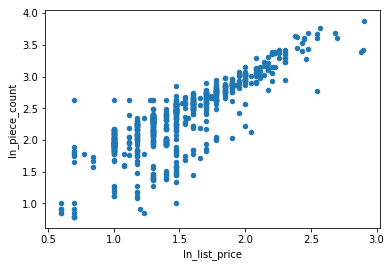

In [168]:
data_US.plot(kind = 'scatter', x = 'ln_list_price', y = 'ln_piece_count');

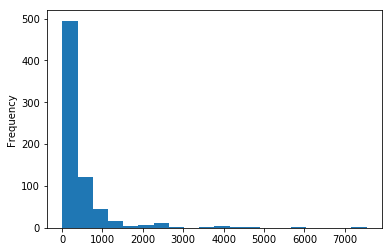

In [170]:
data_US['piece_count'].plot(kind = 'hist', bins = 20);

In [174]:
target = 'ln_list_price'
features = [
    
    'piece_count',
    'piece_count^2',
    'age_mean',
    'age_mean^2',
    'num_reviews',
    'star_rating',
    'star_rating^2',
    #'val_star_rating',
    #'play_star_rating',
    'review_diff_int',
    'desc_word_count',
    'desc_bullet_count',
    #'cont_tm',
    'cont_lego',
    'cont_battery',
    
]

X_train, X_test, y_train, y_test = train_test_split(data_US[features], data_US[target], test_size=0.2)

model = sm.OLS(y_train.values, X_train).fit()

lin_model = LinearRegression().fit(X_train, y_train)

print('train r^2 score: ' + str(r2_score(y_train, lin_model.predict(X_train))))
print('test r^2  score: ' + str(r2_score(y_test,lin_model.predict(X_test))))
print('train RMSE score: ' + str(np.sqrt(mean_squared_error(y_train,lin_model.predict(X_train)))))
print('test RMSE  score: ' + str(np.sqrt(mean_squared_error(y_test,lin_model.predict(X_test)))))

model.summary()

#mse
#mae

train r^2 score: 0.7632238858126564
test r^2  score: 0.7181537808851088
train RMSE score: 0.1945444968124475
test RMSE  score: 0.20848266299900511


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2801.
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:40:54   Log-Likelihood:                 118.79
No. Observations:                 572   AIC:                            -213.6
Df Residuals:                     560   BIC:                            -161.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
piece_count           0.0008   3.44e-05     23.967      0.000       0.001       0.001
piece_count^2     -9.572e-08   5.77e-09    -16.579      0.000   -1.07e-07   -8.44e-08
age_mean              0.0143      0.009      1.550      0.122      -0.004       0.032
age_mean^2           -0.0018      0.000     -4.040      0.000      -0.003      -0.001
num_reviews           0.0001      0.000      0.304      0.761      -0.001       0.001
star_rating           0.5697      0.038     14.954      0.000       0.495       0.645
star_rating^2        -0.0743      0.006    -12.140      0.000      -0.086      -0.062
review_diff_int       0.0735      0.015      5.033      0.000       0.045       0.102
desc_word_count       0.0001   3.86e-05      3.478      0.001    5.85e-05       0.000
desc_bullet_count    -0.0143      0.005     -2.908      0.004      -0.024      -0.005
cont_lego             0.0580      0.026      2.269      0.024       0.008       0.108
cont_battery          0.1306      0.072      1.811      0.071      -0.011       0.272
==============================================================================
Omnibus:                       19.165   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.900
Skew:                           0.052   Prob(JB):                     2.93e-10
Kurtosis:                       4.353   Cond. No.                     3.25e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
all_parts = ['NNP', 'IN', 'NN', 'CC', 'VB', 'RP', 'DT', '.']

def get_parts_of_speech(prod_desc):
    
    tokens = nltk.word_tokenize(prod_desc)
    text = nltk.Text(tokens)
    tagged = nltk.pos_tag(text)

    counts = defaultdict(int)
    for word, tag in tagged:
        counts[tag] += 1
    total = sum(counts.values())
    #counts_norm = dict((el,0) for el in all_parts)
    counts_norm = dict((word, float(count)/total) for word,count in counts.items())
    #counts_norm = {word:float(count)/total for word,count in counts.items()}
    
    return counts_norm

#for part_of_speech in all_parts:
    
    #data_US[part_of_speech] = data_US['prod_desc'].apply(lambda x: get_parts_of_speech(x)[part_of_speech])
    
#data_US[part_of_speech] = data_US['prod_desc'].apply(lambda x: get_parts_of_speech(x)[part_of_speech])

#get_parts_of_speech(data_US['prod_desc'][2])